In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import tensorflow_hub as hub
import seaborn as sns
import tensorflow_hub as hub
from tensorflow.keras import models, layers
import os
import matplotlib.pyplot as plt


In [8]:
import os

# walk through  the pizza_steak

for dirpath,dirnames,filenames in os.walk("../data/severityDataset"):
  print(f"there are {len(dirnames)} directories and {len(filenames)} files in {dirpath}")

there are 2 directories and 1 files in ../data/severityDataset
there are 4 directories and 1 files in ../data/severityDataset/test
there are 0 directories and 36 files in ../data/severityDataset/test/Healthy
there are 0 directories and 35 files in ../data/severityDataset/test/High
there are 0 directories and 29 files in ../data/severityDataset/test/low
there are 0 directories and 37 files in ../data/severityDataset/test/Medium
there are 4 directories and 1 files in ../data/severityDataset/train
there are 0 directories and 104 files in ../data/severityDataset/train/Healthy
there are 0 directories and 94 files in ../data/severityDataset/train/High
there are 0 directories and 114 files in ../data/severityDataset/train/low
there are 0 directories and 111 files in ../data/severityDataset/train/Medium


In [63]:
import pathlib
import numpy as np

data_dir=pathlib.Path("../data/severityDataset/train/")

# remove .DS_Store file

import os

class_names=np.array(sorted([item.name for item in data_dir.glob('*') if item.name != ".DS_Store"]))


print(class_names)


['Healthy' 'High' 'Medium' 'low']


In [11]:
# Let's visualize our image
import matplotlib.pyplot as plt
import matplotlib.image as mping
import random

def view_random_image(target_dir,target_class):
  target_folder=target_dir+target_class

  random_image=random.sample(os.listdir(target_folder),1)

  # read in the image and plot it using matplotlib

  img=mping.imread(target_folder+"/"+random_image[0])

  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"the shape of the image is {img.shape}") # show the shape of the image



the shape of the image is (256, 256, 3)


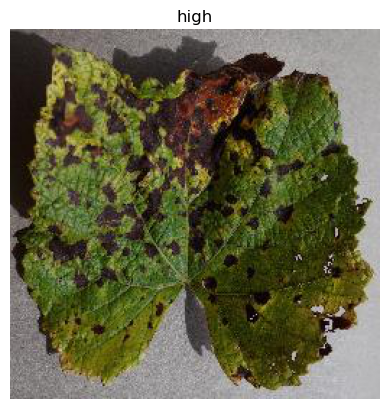

In [15]:
view_random_image("../data/severityDataset/train/","high")

## An end-to-end example

Let's build a convolutional neural network to find patterns in our images, more specifically we a need way to:

* Load our images
* Preprocess our images
* Build a CNN to find patterns in our images
* Compile our CNN
* Fit the CNN to our training data

In [16]:
 # import tensorflow

import tensorflow as tf
import tensorflow_hub as hub

print("Tenserflow version",tf.__version__)
print("Tenserflow Hub version",hub.__version__)

# check GPU
print("GPU" ,"Available (Yes)" if tf.config.list_physical_devices("GPU") else "Not Available 😢")

Tenserflow version 2.12.0
Tenserflow Hub version 0.14.0
GPU Available (Yes)


### 1. Become one with data

the shape of the image is (256, 256, 3)
the shape of the image is (256, 256, 3)
the shape of the image is (256, 256, 3)
the shape of the image is (256, 256, 3)
the shape of the image is (256, 256, 3)
the shape of the image is (256, 256, 3)
the shape of the image is (256, 256, 3)
the shape of the image is (256, 256, 3)
the shape of the image is (256, 256, 3)
the shape of the image is (256, 256, 3)
the shape of the image is (256, 256, 3)
the shape of the image is (256, 256, 3)
the shape of the image is (256, 256, 3)
the shape of the image is (256, 256, 3)
the shape of the image is (256, 256, 3)
the shape of the image is (256, 256, 3)
the shape of the image is (256, 256, 3)
the shape of the image is (256, 256, 3)


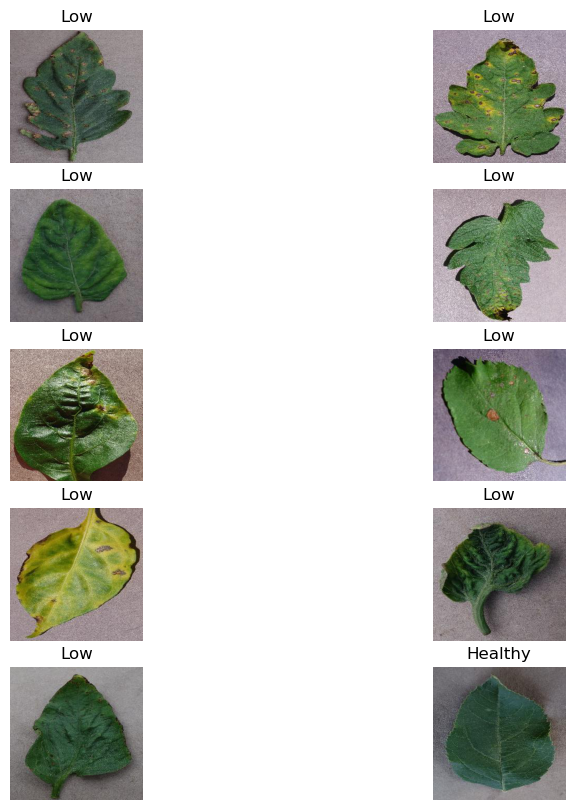

In [45]:
# visualize data

plt.figure(figsize=(10,10))
for i in range(1,10):
  plt.subplot(5,2,i) # row , col , sub plot
  medium=view_random_image("../data/severityDataset/train/","Low")
  plt.subplot(5,2,i+1)

  high=view_random_image("../data/severityDataset/train/","Healthy")


### 2.Preprocess the data (prepare it for a model)


In [46]:
# set paths
train_dir="../data/severityDataset/train"
test_dir="../data/severityDataset/test"

In [47]:
# create train and test data generators and rescale the data


from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen=ImageDataGenerator(rescale=1/225.) # rescale all the pixel to 255
test_datagen=ImageDataGenerator(rescale=1/225.) # rescale all the pixel to 255

In [49]:
# load in our image data from directories and turn them into bateches

# create an augmented data

train_datagen_augmented=ImageDataGenerator(
    rescale=1/225.,
    rotation_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
);

train_data=train_datagen_augmented.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode="categorical"
)

test_data=test_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode="categorical"
)


Found 421 images belonging to 4 classes.


Found 133 images belonging to 4 classes.


In [59]:
train_data.class_mode

'categorical'

In [65]:
# set number of images to use for experimenting

NUM_IMAGES=1000 #@param {types:"sliders",min:1000,max:10000}

BATCH_SIZE = 32

IMG_SIZE=224

In [98]:
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3]  # batch , height,width,color

# setup output shape of our model
OUTPUT_SHAPE = len(class_names)

# model url from Tenserflow hub
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"
mobilenet ="https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"



### 3. Create a model (start with a baseline)

In [73]:
# create a function to build the model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=efficientnet_url):
  print("Building the model 🏗️ ",input_shape,output_shape,model_url)
  with tf.device('/device:GPU:0'):
    # 1 .create the model
    model = tf.keras.Sequential([
        hub.KerasLayer(model_url), # Layer 1 (input layer)
        tf.keras.layers.Dense(
            units=OUTPUT_SHAPE,
            activation="softmax"  # layer 2 (output layer)
        )
    ])

    # 2.compile the model
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.legacy.Adam(),
        metrics=["accuracy"]
    )

    # 3.build the model
    model.build(input_shape)

  return model


In [74]:
model=create_model()

Building the model 🏗️  [None, 224, 224, 3] 4 https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1


In [75]:
model.fit(
    train_data,
    epochs=100,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data)

)

Epoch 1/100
14/14 [==============================] - 10s 467ms/step - loss: 1.3624 - accuracy: 0.3302 - val_loss: 1.1502 - val_accuracy: 0.4436
Epoch 2/100
14/14 [==============================] - 4s 290ms/step - loss: 1.0861 - accuracy: 0.5534 - val_loss: 1.0657 - val_accuracy: 0.4436
Epoch 3/100
14/14 [==============================] - 4s 297ms/step - loss: 0.9138 - accuracy: 0.6817 - val_loss: 0.9519 - val_accuracy: 0.5263
Epoch 4/100
14/14 [==============================] - 5s 340ms/step - loss: 0.8373 - accuracy: 0.7078 - val_loss: 0.9304 - val_accuracy: 0.5263
Epoch 5/100
14/14 [==============================] - 4s 282ms/step - loss: 0.7775 - accuracy: 0.7292 - val_loss: 0.9045 - val_accuracy: 0.5564
Epoch 6/100
14/14 [==============================] - 4s 266ms/step - loss: 0.7193 - accuracy: 0.7601 - val_loss: 0.8775 - val_accuracy: 0.5789
Epoch 7/100
14/14 [==============================] - 4s 256ms/step - loss: 0.6639 - accuracy: 0.7767 - val_loss: 0.8770 - val_accuracy: 0.563

In [76]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 1280)              4049564   
                                                                 
 dense_2 (Dense)             (None, 4)                 5124      
                                                                 
Total params: 4,054,688
Trainable params: 5,124
Non-trainable params: 4,049,564
_________________________________________________________________
None


In [77]:
print(model.evaluate(test_data))

5/5 [==============================] - 1s 171ms/step - loss: 0.9321 - accuracy: 0.6917
[0.9320567846298218, 0.6917293071746826]


In [82]:
save_model(model, "efficient_net_model_1")

Saving model to: ./models/severityModel/20231120-22341700499877-efficient_net_model_1.h5...


'./models/severityModel/20231120-22341700499877-efficient_net_model_1.h5'

In [99]:
mobilenet_model=create_model(model_url=mobilenet)

Building the model 🏗️  [None, 224, 224, 3] 4 https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [84]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Activation
from tensorflow.keras import Sequential


In [91]:
# 1.create a model

model_2=Sequential([
  Conv2D(10, 3, input_shape=(224, 224, 3)),
  Activation(activation="relu"),
  Conv2D(10, 3, activation="relu"),
  MaxPool2D(),
  Conv2D(10, 3, activation="relu"),
  Conv2D(10, 3, activation="relu"),
  MaxPool2D(),
  Flatten(),
  Dense(4, activation="softmax") # changed to have 10 output neurons and use the softmax activation function
])

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=["accuracy"]
                )

In [94]:

# 3. fit the model

history_2=model_2.fit(
                train_data, # now 10 different classes
                        epochs=150,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data)
)

Epoch 1/150
14/14 [==============================] - 3s 231ms/step - loss: 1.1506 - accuracy: 0.4679 - val_loss: 1.0732 - val_accuracy: 0.5714
Epoch 2/150
14/14 [==============================] - 3s 192ms/step - loss: 1.1174 - accuracy: 0.5273 - val_loss: 1.0361 - val_accuracy: 0.6015
Epoch 3/150
14/14 [==============================] - 3s 194ms/step - loss: 1.0757 - accuracy: 0.5439 - val_loss: 1.0875 - val_accuracy: 0.5338
Epoch 4/150
14/14 [==============================] - 3s 183ms/step - loss: 1.0698 - accuracy: 0.5202 - val_loss: 1.0277 - val_accuracy: 0.5940
Epoch 5/150
14/14 [==============================] - 3s 189ms/step - loss: 1.0702 - accuracy: 0.5107 - val_loss: 1.0304 - val_accuracy: 0.5789
Epoch 6/150
14/14 [==============================] - 3s 189ms/step - loss: 1.0789 - accuracy: 0.5249 - val_loss: 1.0632 - val_accuracy: 0.5865
Epoch 7/150
14/14 [==============================] - 3s 188ms/step - loss: 1.1036 - accuracy: 0.4869 - val_loss: 1.1134 - val_accuracy: 0.5188

In [95]:
print(model_2.evaluate(test_data))

5/5 [==============================] - 0s 29ms/step - loss: 1.5669 - accuracy: 0.7068
[1.5668621063232422, 0.7067669034004211]


In [96]:
save_model(model_2, "tiny_VGG_model_1")

Saving model to: ./models/severityModel/20231120-22501700500857-tiny_VGG_model_1.h5...


'./models/severityModel/20231120-22501700500857-tiny_VGG_model_1.h5'

In [101]:
predictions=model_2.predict(test_data)

5/5 [==============================] - 0s 53ms/step


In [104]:
def load_and_pred_image(filename,img_shape=224):
  """
  Read an image from filename, turns it inot a tensor and resize the shape to (img_shape,img_shape,color_channels)
  """

  # read in the imge
  img=tf.io.read_file(filename)

  # decode the image
  img=tf.image.decode_image(img)

  # resize the image

  img_resize=tf.image.resize(img,size=[img_shape,img_shape])

  # rescale the image
  img_rescale=img_resize/255.

  return img_rescale

In [105]:
def get_top_prediction(preds):
  max_pred=preds.argmax()
  pred_class=class_names[max_pred]

  return pred_class


# method to plot the predictions

def plot_top_predictions(preds):
  plt.bar(np.arange(len(preds)), # x
                      preds, # y
                      color="grey"
                      )

  plt.xticks(np.arange(len(preds)),
              labels=class_names,
              rotation="vertical",
              )




In [106]:
# Reconfig the pred_and_plt_function
def pred_and_plot(model,filename:str,class_names=class_names):
  """
  imports an image with given filename , make prediction with model and
  plots the image with the predicted class as the title
  """

  # import the target iamge and preprocess it

  img=load_and_pred_image(filename)
  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)


  # make preictions

  pred=model.predict(tf.expand_dims(img,axis=0))

  # get the predlabel
  pred_label=get_top_prediction(pred[0])

  plt.imshow(img)
  plt.axis("off")
  #set the title
  plt.title(f"Prediction : {pred_label}",color="purple")

  plt.subplot(1,2,2)

  plot_top_predictions(pred[0])


1/1 [==============================] - 0s 13ms/step


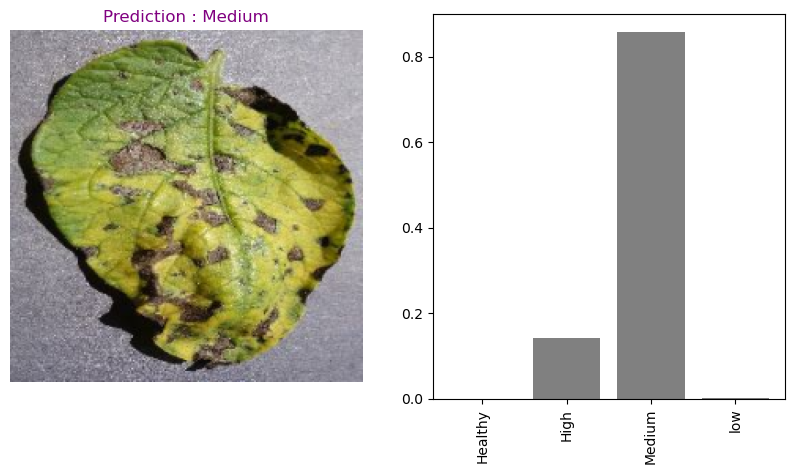

In [120]:
pred_and_plot(filename='/Volumes/Project-2/programming/machine_deep_learning/DL-project/data/severityDataset/test/Medium/86562214-f8b9-4105-9513-4847520aff9a___RS_Early.B 7515_180deg.JPG',model=model_2)

## 4. Evaluate the model

In [83]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss=history.history["loss"]
  val_loss=history.history["val_loss"]

  accuracy=history.history["accuracy"]
  val_accuracy=history.history["val_accuracy"]

  epochs=range(len(history.history["loss"])) # how many epochs are ther


  #plot loss

  plt.plot(epochs,loss,label="training loss")
  plt.plot(epochs,val_loss,label="validation loss")
  plt.title("loss curve")
  plt.xlabel("epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs,accuracy,label="training accuracy")
  plt.plot(epochs,val_accuracy,label="validation accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()


## Saving and reloading a trained model

In [80]:
# Create a function to save a model
import datetime
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (string).
  """
  # Create a model directory pathname with current time
  modeldir = os.path.join("./models/severityModel/",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [81]:
# Create a function to load a trained model
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model